# Machine Listening (Fall 2020)
# Lab4: Speech Analysis

# lab4-1 : Pitch analysis using autocorrelation

get authorization to read audio files in google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


code to record audio

In [2]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})


var record = time => new Promise(async resolve => {

  
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(folder='/content/drive/My Drive/machine_listening_2020/lab/lab4/audio.wav',sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open(folder,'wb') as f:
    f.write(b)
    f.close()
  return 'audio.wav'

record audio

In [3]:
record(sec=3)  # change recording time

<IPython.core.display.Javascript object>

'audio.wav'

read recorded audio

In [4]:
import librosa
import IPython.display as ipd


audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab4/audio.wav'


audio, sr = librosa.load(audio_path, sr=16000)
print('sample rate of this audio file :', sr, 'Hz')

print('sample length of this audio file :', len(audio)/sr, 's')
ipd.Audio(audio, rate=sr, autoplay=False) # play audio


sample rate of this audio file : 16000 Hz
sample length of this audio file : 2.88 s


show waveform of recorded audio

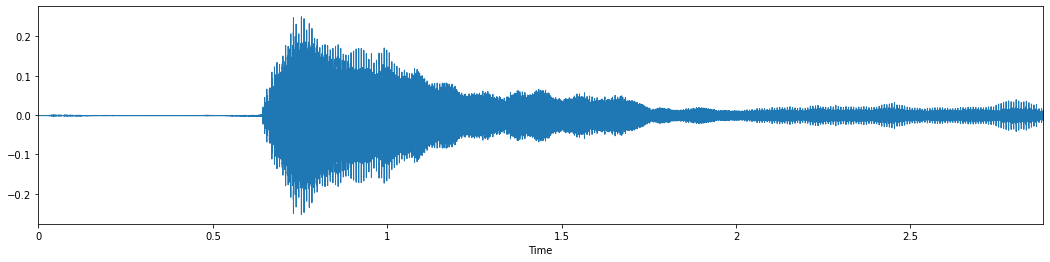

In [5]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(18,4))
librosa.display.waveplot(audio, sr)
plt.show()

slice recorded audio

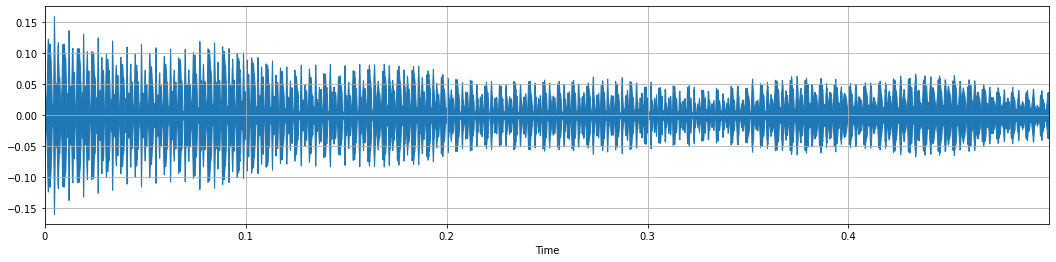

In [6]:
start_time = 1.
end_time = 1.5

audio_sep = audio[int(start_time*sr):int(end_time*sr)]
plt.figure(figsize=(18,4))
librosa.display.waveplot(audio_sep, sr)
plt.grid()
plt.show()

show magnitude spectrum of recorded audio

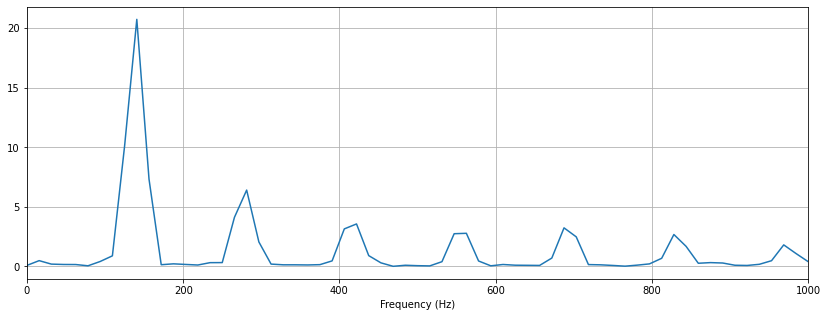

In [7]:
import numpy as np
nfft = 1024
winlen = nfft
window = np.hamming(winlen)
X = np.abs(np.fft.fft(window*audio_sep[:nfft],nfft))
fi = np.arange(0,sr,sr/nfft) # freq. resolution = fs/nfft

plt.figure(figsize=(14, 5))
plt.plot(fi, X)
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 1000)
plt.grid()
plt.show()

compute autocorrelation and plot

(8000,)


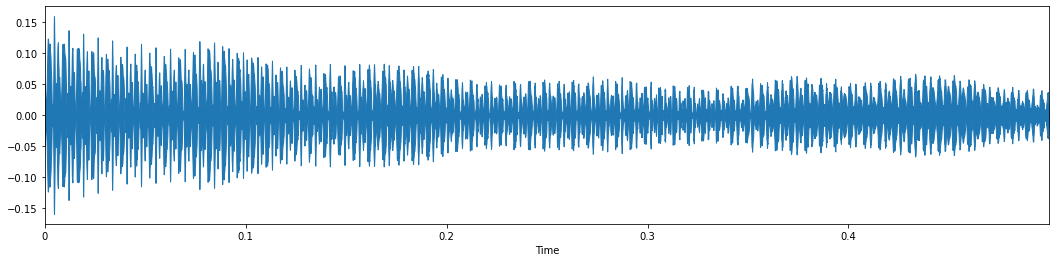

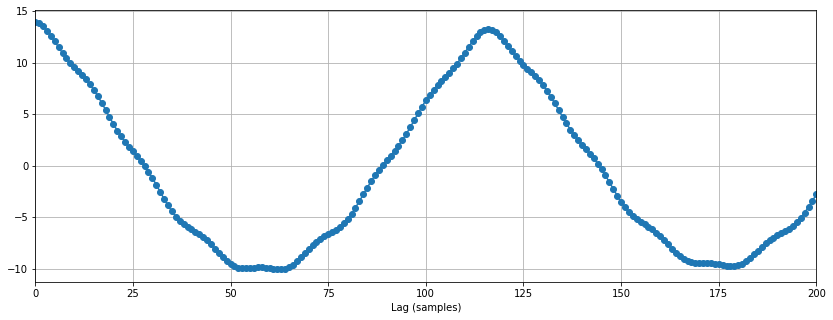

In [8]:
x = audio_sep
plt.figure(figsize=(18,4))
librosa.display.waveplot(x, sr)


r = librosa.autocorrelate(x, max_size=10000)
print(r.shape)
plt.figure(figsize=(14, 5))
plt.plot(r,'o-')
plt.xlabel('Lag (samples)')
plt.xlim(0, 200)
plt.grid()
plt.show()


In [9]:
16000/115

139.1304347826087

# lab4-2 : Cepstral analysis

compute and plot cepstrum

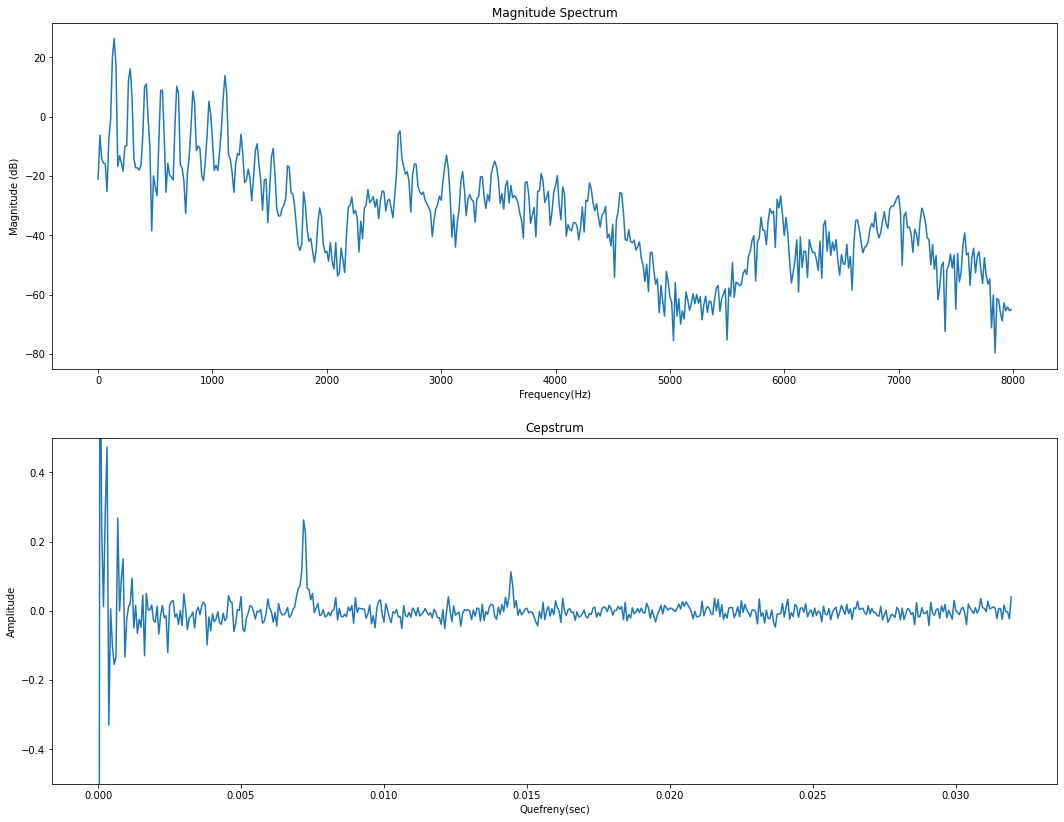

In [10]:
nfft = 1024
overlap = 3*nfft/4
hop = 512
winlen = nfft
window = np.hamming(winlen)

x = audio_sep[:nfft]

x_windowed = x * window
X = np.fft.fft(x_windowed, nfft)
c_r = np.fft.ifft(np.log(np.abs(X) + np.finfo(float).eps), nfft).real

fi = np.arange(0, sr // 2, sr / nfft)
plt.figure(figsize=(18,14))
plt.subplot(2,1,1)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(fi, 20 * np.log10(np.abs(X[:len(X) // 2]  + np.finfo(float).eps)))
#plt.xlim(0,1000)

plt.subplot(2,1,2)
ti = np.arange(0, winlen / sr, 1/sr)
plt.title('Cepstrum')
plt.xlabel('Quefreny(sec)')
plt.ylabel('Amplitude')
plt.ylim([-0.5,0.5])
plt.plot(ti[:len(c_r) // 2],c_r[:len(c_r) // 2])


compute spectral envelope by liftering the cepstrum, and plot 

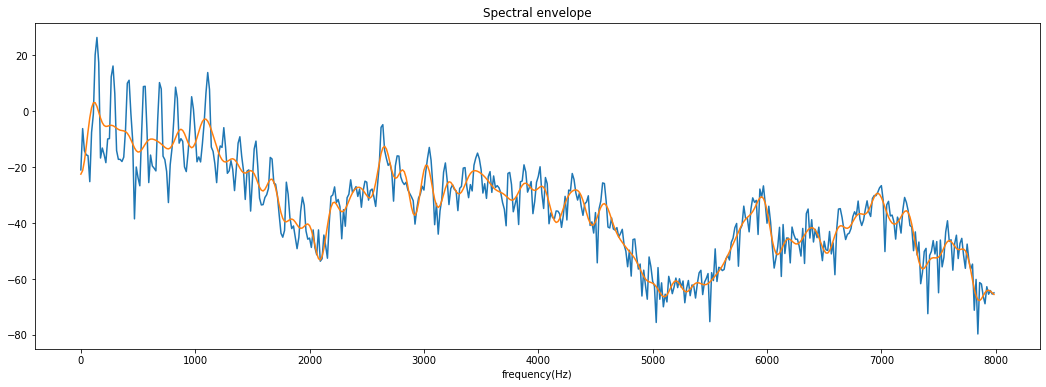

In [11]:
N1 = 100

window_lowpass = np.array([1] + [2] * N1 + [0] * (len(c_r) - 1 - N1))
c_lowpass = c_r * window_lowpass
se = 20*np.log10(np.exp(np.fft.fft(c_lowpass))+np.finfo(float).eps)
# se = np.fft.fft(c_lowpass)+np.finfo(float).eps
fi = np.arange(0, sr // 2, sr / nfft)


plt.figure(figsize=(18,6))

#without liftering
#plt.plot(fi, np.abs(np.fft.fft(c_r, nfft)[:nfft//2]))
plt.plot(fi, 20 * np.log10(np.abs(X[:len(X) // 2]  + np.finfo(float).eps)))

#with liftering
#plt.plot(fi, np.abs(c_lowpass[:nfft//2]))
plt.plot(fi, se[:nfft//2].real)
plt.title('Spectral envelope')
plt.xlabel('frequency(Hz)')
plt.show()
